<a href="https://colab.research.google.com/github/dondreojordan/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [75]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [76]:
import numpy as np
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from pandas_profiling import ProfileReport
import plotly.express as px
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split, cross_val_predict

In [77]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [78]:
from sklearn.model_selection import cross_val_predict

In [79]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer


In [80]:
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

In [81]:
def clean(X):
    X = X.copy()   
    # anything around zero needs to be 0 to remove
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    # drop duplicates
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    # replace the zeros with nulls
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)        
    # convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    # Get more precise dates to increase accuracy 
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    # Now you can get another important feature based on age since construction
    X['years'] = X['year_recorded'] - X['construction_year']
    X['age'] = X['years'].isnull()
    # Drop High cardinality
    X = X.drop(['scheme_name','funder','installer'], axis=1)
    # drop low variance column
    X = X.drop(['recorded_by'], axis=1)
    # return the cleaned dataframe
    return X
train = clean(train)
val = clean(val)
test = clean(test)




print("Check Train Shape: ",train.shape, "\nCheck Validation Shape", val.shape,"\nCheck Test Shape", test.shape)

Check Train Shape:  (47520, 39) 
Check Validation Shape (11880, 39) 
Check Test Shape (14358, 38)


In [82]:
train.head()

,id,amount_tsh,gps_height,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,year_recorded,month_recorded,day_recorded,years,age
43360,72938,0.0,NaN,33.542898,-9.174777,Kwa Mzee Noa,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,NaN,True,VWC,NaN,NaN,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2011,7,27,NaN,True
7263,65358,500.0,2049.0,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,Rufiji,Kitichi,Iringa,11,4,Njombe,Imalinyi,175.0,True,WUA,True,2008.0,gravity,gravity,gravity,wua,user-group,pay monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2011,3,23,3.0,False
2486,469,25.0,290.0,38.238568,-6.179919,Kwasungwini,0,Wami / Ruvu,Kwedigongo,Pwani,6,1,Bagamoyo,Mbwewe,2300.0,True,VWC,False,2010.0,india mark ii,india mark ii,handpump,vwc,user-group,pay per bucket,salty,salty,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional,2011,3,7,1.0,False
313,1298,0.0,NaN,30.716727,-1.289055,Kwajovin 2,0,Lake Victoria,Kihanga,Kagera,18,1,Karagwe,Isingiro,NaN,True,NaN,True,NaN,other,other,other,vwc,user-group,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other,non functional,2011,7,31,NaN,True
52726,27001,0.0,NaN,35.389331,-6.399942,Chama,0,Internal,Mtakuj,Dodoma,1,6,Bahi,Nondwa,NaN,True,VWC,True,NaN,mono,mono,motorpump,vwc,user-group,pay per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional,2011,3,10,NaN,True


In [83]:
val.head()

,id,amount_tsh,gps_height,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,year_recorded,month_recorded,day_recorded,years,age
3290,67999,0.0,NaN,31.509864,-1.153080,Kwawilliam,0,Lake Victoria,Nyakalembe,Kagera,18,7,Misenyi,Kassambya,NaN,True,VWC,True,NaN,swn 80,swn 80,handpump,vwc,user-group,never pay,soft,good,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional,2011,7,9,NaN,True
47666,9256,2000.0,1576.0,29.838600,-4.429692,Nyamakanka,0,Lake Tanganyika,Kishengezi B,Kigoma,16,2,Kasulu,Muhinda,1.0,True,Water authority,False,1991.0,other,other,other,vwc,user-group,pay annually,soft,good,insufficient,spring,spring,groundwater,improved spring,improved spring,functional,2013,2,5,22.0,False
2538,3168,25.0,898.0,37.748364,-4.061791,Kwa Mama Juma,0,Pangani,Majevu A,Kilimanjaro,3,3,Same,Same Urban,420.0,True,Water authority,NaN,2011.0,submersible,submersible,submersible,private operator,commercial,pay per bucket,salty,salty,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional,2013,3,28,2.0,False
53117,19684,0.0,NaN,33.380346,-3.132556,Lahu B,0,Lake Victoria,Lahu,Mwanza,19,4,Kwimba,Nyamilama,NaN,NaN,VWC,True,NaN,swn 80,swn 80,handpump,vwc,user-group,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional,2011,7,25,NaN,True
51817,42303,0.0,548.0,37.648831,-6.725480,Chazo Cha Kilongo,0,Wami / Ruvu,Kiloka,Morogoro,5,5,Morogoro Urban,Kihonda,500.0,True,VWC,True,1985.0,other,other,other,vwc,user-group,never pay,soft,good,enough,machine dbh,borehole,groundwater,other,other,non functional,2011,8,3,26.0,False


In [84]:
test.head()

,id,amount_tsh,gps_height,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,year_recorded,month_recorded,day_recorded,years,age
0,50785,0.0,1996.0,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321.0,True,Parastatal,True,2012.0,other,other,other,parastatal,parastatal,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other,2013,2,4,1.0,False
1,51630,0.0,1569.0,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300.0,True,VWC,True,2000.0,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,2013,2,4,13.0,False
2,17168,0.0,1567.0,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500.0,True,VWC,NaN,2010.0,other,other,other,vwc,user-group,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other,2013,2,1,3.0,False
3,45559,0.0,267.0,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250.0,NaN,VWC,True,1987.0,other,other,other,vwc,user-group,unknown,soft,good,dry,shallow well,shallow well,groundwater,other,other,2013,1,22,26.0,False
4,49871,500.0,1260.0,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60.0,NaN,Water Board,True,2000.0,gravity,gravity,gravity,water board,user-group,pay monthly,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2013,3,27,13.0,False


In [85]:
train['status_group'].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

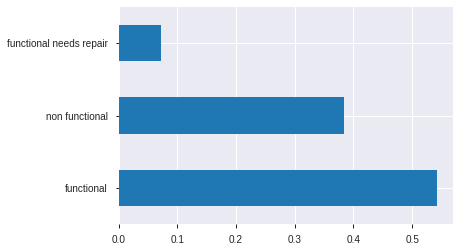

In [86]:
train['status_group'].value_counts(normalize=True).plot(kind='barh');

In [87]:
# the status_group column is the target
target = 'status_group'

# get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Get a list of all categorical features with cardinality >=50
high_cardinality= cardinality[cardinality > 50].index.tolist()

# combine the lists 
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'year_recorded', 'month_recorded', 'day_recorded', 'years', 'basin', 'region', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'age']


In [88]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test
y_test = test[features]

In [89]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)

(47520, 33)
(47520,)
(11880, 33)
(11880,)
(14358, 38)


In [90]:
model = Pipeline([
                  ('ohe', OneHotEncoder()),
                  ('impute', SimpleImputer()),
                  ('classifier', RandomForestClassifier(n_jobs=-1))
])

model.fit(X_train, y_train)

print('training accuracy:', model.score(X_train, y_train))
print('validation accuracy:', model.score(X_val, y_val))

training accuracy: 0.997895622895623
validation accuracy: 0.8094276094276094


In [91]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(random_state=0, n_jobs=-1, criterion='entropy', n_estimators=300, oob_score=True))
pipeline.fit(X_train, y_train)
print('training accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

training accuracy: 0.9979377104377104
Validation Accuracy 0.8104377104377104


In [92]:
y_train = y_train != 'functional'
y_val = y_val  != 'functional'

In [93]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

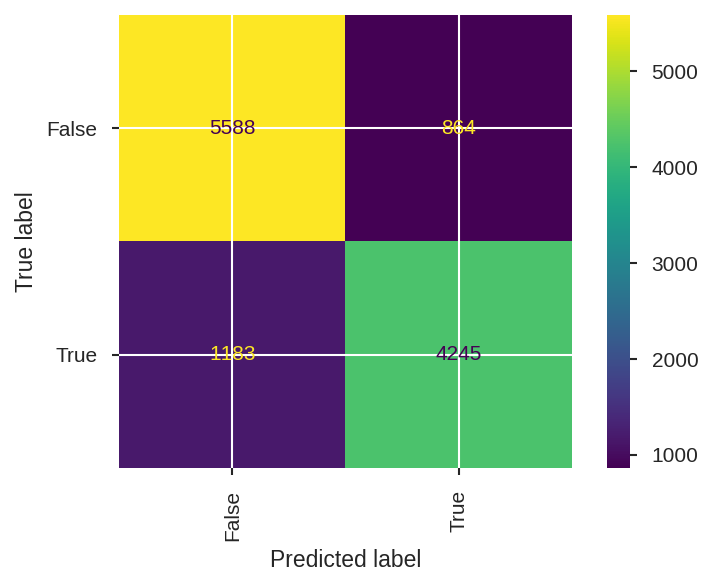

In [94]:
from sklearn.metrics import plot_confusion_matrix, classification_report

plt.rcParams['figure.dpi'] = 150
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical');

In [95]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.83      0.87      0.85      6452
        True       0.83      0.78      0.81      5428

    accuracy                           0.83     11880
   macro avg       0.83      0.82      0.83     11880
weighted avg       0.83      0.83      0.83     11880



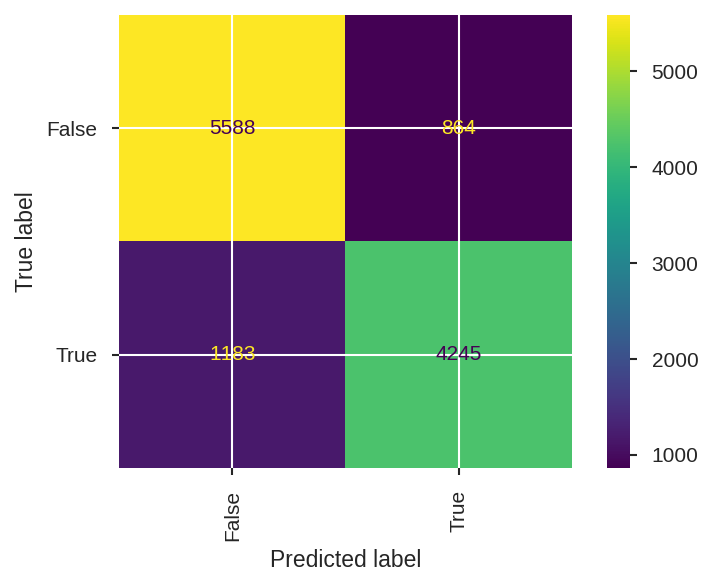

In [96]:
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical');

In [97]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.83      0.87      0.85      6452
        True       0.83      0.78      0.81      5428

    accuracy                           0.83     11880
   macro avg       0.83      0.82      0.83     11880
weighted avg       0.83      0.83      0.83     11880



In [98]:
y_pred = pipeline.predict(X_val)
y_pred_proba = pipeline.predict_proba(X_val)

In [99]:
y_pred.shape

(11880,)

In [100]:
y_pred

array([ True, False, False, ...,  True, False,  True])

In [110]:
#Random Forest Classification w/ Validation Accuracy Score
%%time
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(random_state=0, min_samples_split=8,max_depth=40)
)

#   F I T
pipeline.fit(X_train, y_train)

#Check Metrics
print("Training Accuracy", pipeline.score(X_train, y_train))
print("Validation Accuracy", pipeline.score(X_val, y_val))

Training Accuracy 0.9448232323232323
Validation Accuracy 0.7905723905723906
CPU times: user 8.42 s, sys: 212 ms, total: 8.63 s
Wall time: 8.62 s


In [34]:
%%time
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

CPU times: user 44 µs, sys: 0 ns, total: 44 µs
Wall time: 48.6 µs


In [112]:
#Random Forest Classification w/ Validation Accuracy Score 
%%time
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    RandomForestClassifier(random_state=0, n_jobs=2, n_estimators=199, min_samples_split=8,max_samples=40000,max_depth=40)
)



#   F I T
pipeline.fit(X_train, y_train)

#Check Metrics
print("Training Accuracy", pipeline.score(X_train, y_train))
print("Validation Accuracy", pipeline.score(X_val, y_val))


Training Accuracy 0.9243897306397306
Validation Accuracy 0.8292087542087542
CPU times: user 44.8 s, sys: 292 ms, total: 45.1 s
Wall time: 26.2 s


In [48]:
# Import libraries
import numpy as np
from sklearn import datasets
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [49]:
# Instantiate the standardizier
standardizer = StandardScaler()

# Instantiate the classifier
logreg = LogisticRegression(max_iter=150)

# Create the pipeline
pipeline = make_pipeline(standardizer, logreg)

# Instantiate the k-fold cross-validation 
kfold_cv = KFold(n_splits=5, shuffle=True, random_state=11)

In [50]:
# Fit the model using k-fold cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train,
                           cv=kfold_cv, scoring='accuracy')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: 'Lake Nyasa'

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: 'Lake Nyasa'

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: 'Lake Nyasa'

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit fai

In [ ]:
# Print the mean score
print('All cv scores: ', cv_scores)

# Print the mean score
print('Mean of all cv scores: ', cv_scores.mean())

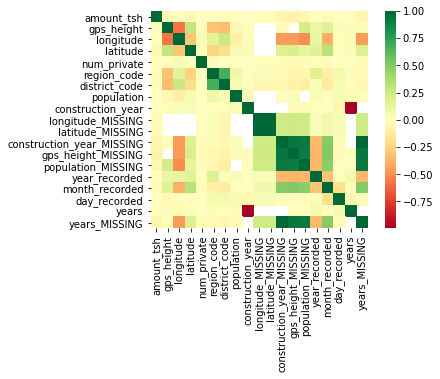

In [42]:
sns.heatmap(train.corr(), square=True, cmap='RdYlGn');

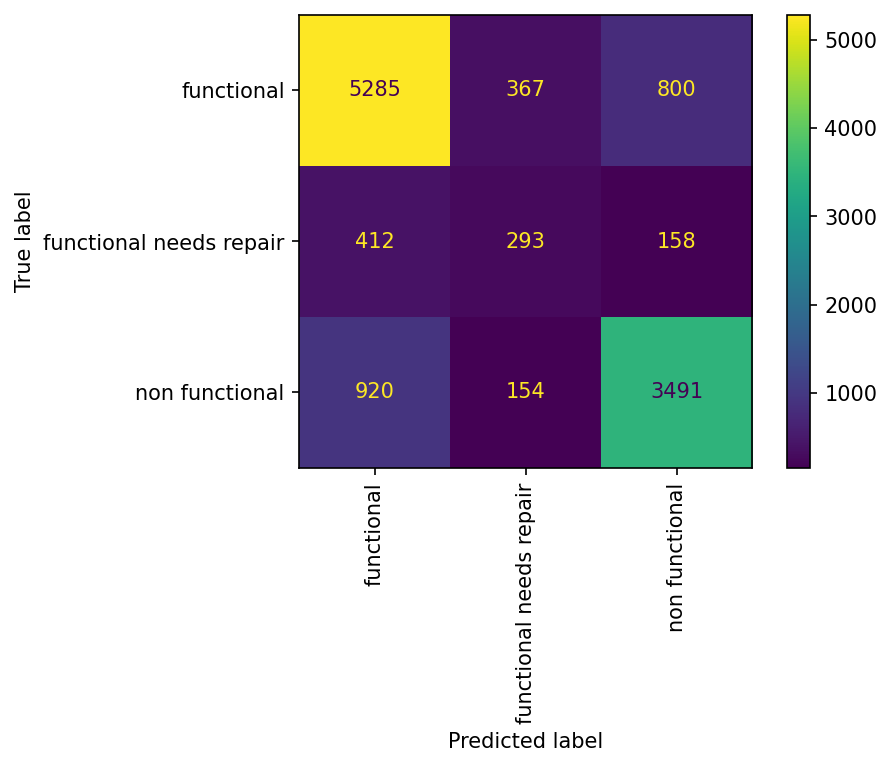

In [43]:
# How to make it more pretty
from sklearn.metrics import plot_confusion_matrix

plt.rcParams['figure.dpi']=150 #Size of matrix
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical');
#value_format = Rounds the numbers
# xticks_rotation = rotate tick labels

Save Work

In [ ]:
#y_pred = pipeline.predict(X_test)
#submission = sample_submission.copy()
#submission['status_group'] = y_pred

In [ ]:
#from google.colab import files
#submission.to_csv('dondre_submission_1.csv', index=False)
#files.download('dondre_submission_1.csv')